In [1]:
using LinearAlgebra
using SparseArrays

In [2]:
"""
Thermal Properties of material

        k      thermal conductivity, W/m2/K  
        rho    density, kg/m3  
        Cp     specific heat, J/kg  
        alpha  thermal diffusivity, m2/s
"""
struct Material
    k     ::Float64
    rho   ::Float64
    Cp    ::Float64
    alpha ::Float64
end

Material(k, rho, Cp) = Material(k, rho, Cp, k/(rho*Cp));

In [3]:
clay = Material(1.28, 880.0, 1450.0) # Clay

Material(1.28, 880.0, 1450.0, 1.0031347962382445e-6)

## v2

In [4]:
""" 
    equation
        M dT/dt = K T  +  S(t)
"""
struct Model
    dt          ::Float64            # time step, seconds
    id_to_index ::Dict{String, Int64}
    M           ::Array{Float64,1}   # thermal mass of each nodes
    K_ijv  ::Array{NamedTuple{(:i,:j,:v),Tuple{Int64,Int64,Float64}}, 1}# Array of named tuple (i, j, value)
    S_iv  #sources -- array of [(idx, function(t)), ()...]
end

Model(dt) = Model(dt,
                  Dict{String,Int64}(),
                  Array{Float64,1}(),
                  [],
                  []);

In [5]:
function add_simplethermalmass!(model, node_id, th_mass)
    if haskey(model.id_to_index, node_id)
        error("""Can't add simple mass: "$node_id", the id already exists""")
    end
    push!(model.M, th_mass)
    model.id_to_index[node_id] = length(model.M)
    return node_id
end

add_simplethermalmass! (generic function with 1 method)

In [6]:
# test
m = Model(5*60)
add_simplethermalmass!(m, "1", 0.1)
add_simplethermalmass!(m, "2", 0.2)

"2"

In [7]:
function add_wall!(model, wall_id, material, thickness, surface)
    # Mesh
    delta_x = sqrt( model.dt * material.alpha )
    N = 1 + Int(ceil( thickness/delta_x ))
    dx = thickness / N
    
    # Register surfaces node index
    i_ext = length(model.M) + 1
    i_int = length(model.M) + N
    
    id_ext = "$(wall_id)_ext"
    id_int = "$(wall_id)_int"
    if haskey(model.id_to_index, id_ext) || haskey(model.id_to_index, id_int)
        error("""Can't add wall: "$wall_id", the id already exists""")
    end
    model.id_to_index[id_ext] = i_ext
    model.id_to_index[id_int] = i_int
    
    is_boundary(i) = (i == i_ext || i == i_int)
    
    # Thermal mass
    massth = (material.rho * material.Cp * dx * surface * (is_boundary(i) ? 0.5 : 1.0)
              for i in i_ext:i_int)
    append!(model.M, massth)

    # Konduction
    k_dx = material.k / dx
    diagonal   = ( (i=i,   j=i,   v=(is_boundary(i) ? -1.0 : -2.0)*k_dx)
                  for i in i_ext:i_int )
    upper_diag = ( (i=i,   j=i+1, v=+k_dx) for i in i_ext:i_int-1 )
    lower_diag = ( (i=i+1, j=i,   v=+k_dx) for i in i_ext:i_int-1 )
    cells = Iterators.flatten((diagonal, upper_diag, lower_diag))
    append!(model.K_ijv, cells) 

    return (ext=id_ext, int=id_int)
end

add_wall! (generic function with 1 method)

In [8]:
function get_sparse_K(model::Model)
    I = map(x->x.i, m.K_ijv)
    J = map(x->x.j, m.K_ijv)
    V = map(x->x.v, m.K_ijv)
    n = length(m.M)
    K = sparse(I, J, V, n, n)
    return K
end

get_sparse_K (generic function with 1 method)

In [9]:
m = Model(5*60)

air_int = add_simplethermalmass!(m, "T_air_int", 24.2)

wall1 = add_wall!(m, "wall1", clay, .20, 4.)

sol = add_simplethermalmass!(m, "T_sol", 4.2)

wall1 = add_wall!(m, "wall2", clay, .10, 4.)

(ext = "wall2_ext", int = "wall2_int")

In [10]:
typeof(m.K_ijv)

Array{NamedTuple{(:i, :j, :v),Tuple{Int64,Int64,Float64}},1}

In [11]:
function add_conductance!(model, id_nodeA, id_nodeB, UA)
    i = model.id_to_index[id_nodeA]
    j = model.id_to_index[id_nodeB]
    
    cells = [(i=i, j=i, v=-UA),
             (i=j, j=j, v=-UA),
             (i=i, j=j, v=+UA),
             (i=j, j=i, v=+UA)] 
    append!(model.K_ijv, cells);
    return nothing
end

add_conductance! (generic function with 1 method)

In [12]:
add_conductance!(m, "ez", wall1[2], 0.1)

KeyError: KeyError: key "ez" not found

In [13]:
add_conductance!(m, air_int, wall1.ext, 0.1)

In [14]:
function add_convectivesource(model, node_id, Tsource, hS)
    i = model.id_to_index[node_id]
    push!(model.K_ijv, (i=i, j=i, v=-hS));
    push!(model.S_iv,  (i=i, v=t -> hS*Tsource(t)))  # more generic args?
    return nothing
end

add_convectivesource (generic function with 1 method)

In [15]:
T_ext(t) = cos(t)
add_convectivesource(m, wall1.int, T_ext, 1.5)

In [16]:
m.S_iv

1-element Array{Any,1}:
 (i = 22, v = var"#18#19"{typeof(T_ext),Float64}(T_ext, 1.5))

In [17]:
mutable struct State
    update_S!   ::Function
    T           ::Array{Float64,1}
    dt          ::Float64
    t           ::Float64
    theta       ::Float64
    I_minus_dtA #::LDLt{Float64,Tridiagonal{Float64,Array{Float64,1}}}
    I_plus_dtA  #::Tridiagonal{Float64,Array{Float64,1}}
    St          ::Array{Float64,1}
end

In [27]:
function init_solver(model; T0=nothing, theta=0.5, t=0.0)
    M = Diagonal(model.M);
    K = get_sparse_K(model);

    A = M\K;
    dt = model.dt
    I_minus_dtA = factorize(I - theta*dt*A)
    I_plus_dtA = I + (1 - theta)*dt*A;

    function update_S!(S, t)
        fill!(S, 0.0)
        foreach(cell->S[cell.i] += cell.v(t), m.S_iv)
        S[:] = M \ S
    end    
    St = zeros(length(model.M));
    update_S!(St, t)
    
    if isnothing(T0)
        T0 = zeros(length(model.M))
    end
    
    return State(
        update_S!,
        T0,
        model.dt,
        t,
        theta,
        I_minus_dtA,
        I_plus_dtA,
        St
    )
end

init_solver (generic function with 1 method)

In [28]:
function iter!(state)
    theta = state.theta
    dt = state.dt
    
    state.t += dt
    old_S = state.St
    state.update_S!(state.St, state.t)
    S_theta = theta*state.St + (1 - theta)*old_S

    state.T = state.I_minus_dtA \ ( state.I_plus_dtA*state.T + dt*S_theta )
    
    return state.t, state.T
end

iter! (generic function with 1 method)

## Test with soil model

In [20]:
using Plots

In [29]:
min = 60.0
hour = 60min
day = 34hour

122400.0

In [30]:
clay = Material(1.28, 880.0, 1450.0) # Clay
m = Model(2hour)

soil = add_wall!(m, "soil", clay, 6.0, 1.)

T_ext(t) = sin(2pi/(7day)*t)
add_convectivesource(m, soil.ext, T_ext, 1.0)
add_convectivesource(m, soil.int, t->0.0, 2.0)

In [106]:
state = init_solver(m);

In [107]:
save = [1, 4, 8];
n_iter = 300;

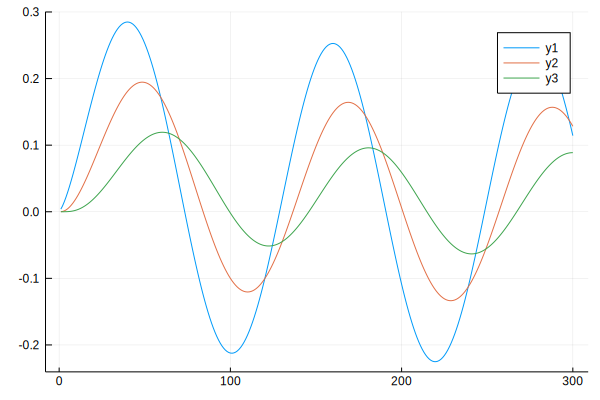

In [108]:
sol = zeros(n_iter, length(save))
for k in 1:n_iter
    iter!(state)
    sol[k, :] = state.T[save]
end
plot(sol)